In [1]:
import pandas as pd            # для предобработки данных
import torch                   # библиотека для работы с нейронными сетями
import lightning.pytorch as pl # библиотека для упрощения процесса обучения нейронных сетей
from pathlib import Path       # для работы с файлами из датасета
import numpy as np             # для работы с данными
from torch import nn  # отдельный модуль (использовался для приведения картинок к одному размеру)
import torchmetrics            # библиотека для подсчета метрик
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score 
                               # использовал метрики и из sklearn
import matplotlib.pyplot as plt

# Обработка датасета

Датасет изначально был разбит на два, что было не совсем удобно, потому что его разбиение планировалось после предобработки, поэтому было принято решение объединить их в один

In [2]:
df = pd.read_json('solaris_damage_0_4_3/train_damage.json').T
df1 = pd.read_json('solaris_damage_0_4_3/val_damage.json').T

В столбце regions находились маски повреждений там, где повреждения были, а где повреждений не было, находились пустые скобки. Т.к. задача состояла в простой бинарной классификации, маски были не нужны, но их наличие позволило быстро и без особых проблем разметить датасет

In [3]:
dt = pd.concat((df1, df))                 # объединение двух частей датасета
df_no_damage = dt[dt.regions == {}]       # разделение данных на датафрейм с повреждениями и без них
df_damage = dt[dt.regions != {}]
df_no_damage['damage'] = 0                # разметка (0 значит нет повреждений, 1 значит есть)
df_damage['damage'] = 1
dt = pd.concat([df_damage, df_no_damage]) # объединение данных, но с разметкой

C:\Users\nicol\AppData\Local\Temp\ipykernel_14540\4010085472.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_damage['damage'] = 0                # разметка (0 значит нет повреждений, 1 значит есть)
C:\Users\nicol\AppData\Local\Temp\ipykernel_14540\4010085472.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_damage['damage'] = 1


In [4]:
class_names = {1 : 'Поврежден', 0 : 'Не поврежден'}

In [5]:
dt # размеченный датасет (добавилась колонка damage)

,fileref,size,filename,base64_img_data,file_attributes,regions,damage
763276261_ph-1594890472763.jpg361325,,361325,763276261_ph-1594890472763.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',...",1
748653201_ph-1590837135746.jpg159030,,159030,748653201_ph-1590837135746.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',...",1
749332798_ph-1591094034047.jpg475242,,475242,749332798_ph-1591094034047.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',...",1
751547262_ph-1591706071695.jpg623101,,623101,751547262_ph-1591706071695.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',...",1
804950356_ph-1604651645539.jpg344353,,344353,804950356_ph-1604651645539.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',...",1
...,...,...,...,...,...,...,...
806726026_ph-1605088324119.jpg382661,,382661,806726026_ph-1605088324119.jpg,,{},{},0
820115261_ph-1608096547764.jpg407289,,407289,820115261_ph-1608096547764.jpg,,{},{},0
865400454_ph-1618394568406.jpg304460,,304460,865400454_ph-1618394568406.jpg,,{},{},0
806757165_ph-1605090862756.jpg121194,,121194,806757165_ph-1605090862756.jpg,,{},{},0


После разметки было интересно проверить данные на дисбаланс классов


In [6]:
dt.damage.value_counts() 

1    2534
0    1739
Name: damage, dtype: int64

In [7]:
2534 / (2534 + 1739)

0.5930259770652937

Таким образом, около 60% данных в датасете показались с повреждениями. Сильного дисбаланса классов нет

## Подготовка данных для создания кастомного датасета

Для начала нужно убедиться, что в моем датафрейме нет данных о файлах, которых нет в папке с картинками

In [8]:
import os              # для работы с файлами
from os import listdir # функция фозвращает список файлов, содержащихся в указанной директории
img_list = []          # список с именами файлов картинок
imgs = []
folder_dir = "C:\\Users\\nicol\\NN\\КУРСАЧ\\solaris_damage_0_4_3\\images" # директория с картинками
for image in os.listdir(folder_dir): # прохожусь циклом по всем картинкам, которые у меня есть
    if (image.endswith(".jpg")):     # проверяю, что это действительно картинка с расширением jpg
        img_list.append(image)       # добавляю имя файла в список
    from PIL import Image
    imgs.append(Image.open(folder_dir +'\\'+ image , mode='r', formats=None))

In [9]:
dt = dt[dt.filename.isin(img_list)] # оставляю только те строки, в которых имя файла есть внутри 
                                    # списка с именами файлов картинок

In [10]:
dt

,fileref,size,filename,base64_img_data,file_attributes,regions,damage
763276261_ph-1594890472763.jpg361325,,361325,763276261_ph-1594890472763.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',...",1
748653201_ph-1590837135746.jpg159030,,159030,748653201_ph-1590837135746.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',...",1
749332798_ph-1591094034047.jpg475242,,475242,749332798_ph-1591094034047.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',...",1
751547262_ph-1591706071695.jpg623101,,623101,751547262_ph-1591706071695.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',...",1
804950356_ph-1604651645539.jpg344353,,344353,804950356_ph-1604651645539.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',...",1
...,...,...,...,...,...,...,...
856556119_ph-1616498258497.jpg506088,,506088,856556119_ph-1616498258497.jpg,,{},{},0
769713076_ph-1596529631205.jpg559567,,559567,769713076_ph-1596529631205.jpg,,{},{},0
752657719_ph-1592042049823.jpg382208,,382208,752657719_ph-1592042049823.jpg,,{},{},0
866706504_ph-1618660738084.jpg449669,,449669,866706504_ph-1618660738084.jpg,,{},{},0


В итогофом датафрейме осталость 4087 наблюдений, было 4273

## Создание кастомного датасета

In [11]:
images = dt['filename'].values                  # array из названий файлов 

In [12]:
images

array(['763276261_ph-1594890472763.jpg', '748653201_ph-1590837135746.jpg',
       '749332798_ph-1591094034047.jpg', ...,
       '752657719_ph-1592042049823.jpg', '866706504_ph-1618660738084.jpg',
       '820115261_ph-1608096547764.jpg'], dtype=object)

In [13]:
classes = dt['damage'].values                    # array с классами для картинок

In [14]:
from torchvision import datasets, transforms     # модуль для перевода картинки в тензор
from torch.utils.data import DataLoader, Dataset # модули для создания датасета и даталоадеров
from skimage import io                           # для работы с картинками
data_path = './solaris_damage_0_4_3/images'      # директория с картинками
trfms =  transforms.Compose([transforms.ToTensor(), # указываю, в какой типа данных нужно перевести картинку
                             transforms.Resize(size=(500, 700))
                             ])# измнение размера картинки
         

In [15]:
class DamageDataset(Dataset):      # класс для кастомного датасета
    def __init__(self, classes, root_dir, images, transform=None):
        self.images = images       # array названий картинок 
        self.classes = classes     # array классов
        self.root_dir = root_dir   # корневая директория 
        self.transform = transform # метод для преобразований

    def __len__(self):
        return len(self.classes)

    def __getitem__(self, idx): 
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.images[idx]) # полный путь к картинке
        image = self.transform(io.imread(img_name)) # считываю картинку и первожу ее в тензор
    
        #image = torch.nn.functional.adaptive_avg_pool2d(image, (500, 700)) # применяю average pooling
                                     # к каждой картинке, чтобы у них был одинаковый размер и при этом
                                     # не менялись общие черты 
        class_ = self.classes[idx]   # класс текущей картинки
        sample = (image, class_)     # формирую необходимый формат аутпута

        return sample

In [16]:
dmg_dataset = DamageDataset(classes = classes, root_dir=data_path, images = images,
                            transform=trfms) # создаю датасет из картинок

C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Поврежден


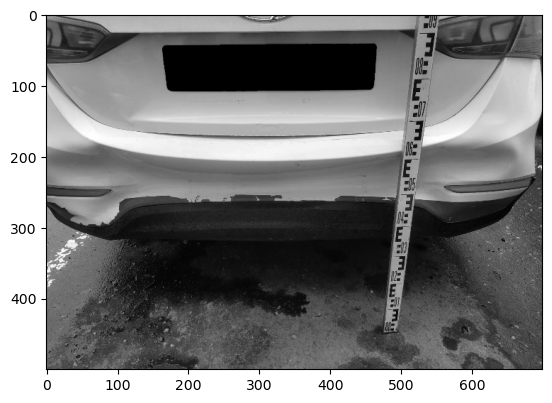

In [17]:
image, label = dmg_dataset[0]
plt.imshow(image[0], cmap = 'gray');
print(class_names[label])

In [18]:
import torch.utils.data as data          # модуль для работы с датасетом
seed = torch.Generator().manual_seed(42) # зерно для случайного разбиения

In [19]:
train_size = int(0.8 * len(dmg_dataset))  # размер данных, которые будут участвовать в обучении
test_size = len(dmg_dataset) - train_size # ращмер тестовых данных
train_dataset, test_set = data.random_split(dmg_dataset, [train_size, test_size], generator=seed)
     # формирую тестовый датаест и датасет из данных, участвующих в обучении

In [20]:
train_set_size = int(len(train_dataset) * 0.8)       # размер тренировочногор датасета 
valid_set_size = len(train_dataset) - train_set_size # размер валидационного датасета

In [21]:
train_set, valid_set = data.random_split(train_dataset, [train_set_size, valid_set_size], generator=seed)
# создание тренировочного и валидационного датасета

In [23]:
import timm # библиотека с предобученными моделями
model = timm.create_model('resnet18', pretrained=True, num_classes = 2)
            # создаю предобученную модель, указываю количество классов
for i, (name, param) in enumerate(model.named_parameters()): # замораживаю все слои, кроме линейных
    if 'fc' in name:
        continue
    else:
        param.requires_grad = False

freezed, unfreezed = 0, 0
for i, param in enumerate(model.parameters()):
    if param.requires_grad:
        unfreezed += 1
    else:
         freezed += 1 
print(f"Замороженных слоев: {freezed}\nНезамороженных: {unfreezed}")
# убеждаюсь, что слои заморожеы

Замороженных слоев: 60
Незамороженных: 2


## Обучение первой модели

Для обучения я использовал библиотеку pytorch lightning

In [24]:
# создаю класс для обучения модели
class ResNet(pl.LightningModule):
    def __init__(self, batch_size = 30, learning_rate = 1e-3):
        super().__init__()
        self.model = model
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.train_acc = torchmetrics.Accuracy(task="binary", num_classes=2)
        self.valid_acc = torchmetrics.Accuracy(task="binary", num_classes=2)
        self.test_acc = torchmetrics.Accuracy(task="binary", num_classes=2)
        self.F1 = torchmetrics.F1Score(task="binary", num_classes=2)
        self.prec = torchmetrics.Precision(task="binary", num_classes=2)
        self.rec = torchmetrics.Recall(task="binary", num_classes=2)
       
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):     # процесс обучения

        X, y = batch
        loss = nn.CrossEntropyLoss()     # в качестве функции потреть выбрана Кросс-энтропия
        pred = torch.argmax(self(X), axis = 1)
        self.train_acc(pred, y)
        self.log("train_loss", loss(self(X), y), on_epoch=True, prog_bar=True,\
                 logger=True, enable_graph = True) # log позволяет сохранять данные 
                                                   # для отображения графиков с поомщбю tensorboard
        self.log('train_acc', self.train_acc, on_epoch=True, prog_bar=True,\
                 logger=True, enable_graph = True)
        
        return loss(self(X), y)

    def validation_step(self, batch, batch_idx):   # процесс валидации
        X, y = batch
        pred = torch.argmax(self(X), axis = 1)     # т.к. модель возвращает нам вероятности 
                                                   # принадлежности объекта к классу, для получения
                                                   # предсказания я беру индекс с наибольшим значением
                                                   # вероятности
        self.valid_acc(pred, y)
        valid_loss = nn.CrossEntropyLoss()
        self.log('valid_loss', valid_loss(self(X), y), on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)
        self.log('valid_acc', self.valid_acc, on_epoch=True, prog_bar=True,\
                 logger=True, enable_graph = True)

    def test_step(self, batch, batch_idx):         # процесс тестирования
        X, y = batch

        acc = self.test_acc(torch.argmax(self(X), axis = 1), y)
        F1 = self.F1(torch.argmax(self(X), axis = 1), y)
        prec = self.prec(torch.argmax(self(X), axis = 1), y)
        rec = self.rec(torch.argmax(self(X), axis = 1), y)
                                                    # произведен подсчет метрик качества
        values = {"acc": acc, "F1": F1, "prec": prec, "rec": rec}
        self.log_dict(values)                       # логировать данные можно и при момощи такого
                                                    # способа, в данном случае он был удобнее

        return values                         

        
    def configure_optimizers(self):                 # оптимизатор скорости обучения
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
   


In [94]:
model_pl = ResNet()

In [95]:
freezed, unfreezed = 0, 0
for i, param in enumerate(model_pl.parameters()):
    if param.requires_grad:
        unfreezed += 1
    else:
         freezed += 1 
print(f"Замороженных слоев: {freezed}\nНезамороженных: {unfreezed}")

Замороженных слоев: 60
Незамороженных: 2


In [29]:
train_loader = DataLoader(train_set, batch_size=30, shuffle=True)  # формирую даталоадеры
valid_loader = DataLoader(valid_set, batch_size=30, shuffle=False)
test_loader = DataLoader(test_set, batch_size=30, shuffle=False)

In [97]:
import time                                                    # для подсчета времени работы модели
start_time = time.time()
trainer = pl.Trainer(limit_train_batches=4000, max_epochs=100) # обхект класса Trainer для обучения
trainer.fit(model_pl, train_loader, valid_loader)              # передаю в него модель и даталоадеры
finish_time = time.time()
lr_time = finish_time - start_time                             # подсчитываю время

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params
----------------------------------------------
0 | model     | ResNet          | 11.2 M
1 | train_acc | BinaryAccuracy  | 0     
2 | valid_acc | BinaryAccuracy  | 0     
3 | test_acc  | BinaryAccuracy  | 0     
4 | F1        | BinaryF1Score   | 0     
5 | prec      | BinaryPrecision | 0     
6 | rec       | BinaryRecall    | 0     
----------------------------------------------
1.0 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.710    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [110]:
info1 = trainer.test(model_pl, test_loader)[0]  # тестирую модель
info1['lr_time'] = lr_time

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            F1             │    0.7217703461647034     │
│            acc            │    0.7053789496421814     │
│           prec            │    0.7918064594268799     │
│            rec            │    0.6699633002281189     │
└───────────────────────────┴───────────────────────────┘

In [109]:
df_info = pd.DataFrame(info1.values()).T
df_info.columns = info1.keys()
df_info.to_excel('info_resnet18.xlsx')
df_info

,acc,F1,prec,rec,lr_time
0,0.705379,0.72177,0.791806,0.669963,26510.280414


## Построение графиков обучения при помощи tensorboard

In [1]:
%reload_ext tensorboard
%tensorboard --logdir model1_resnet18_logs

График accuracy на тренировочном датасете
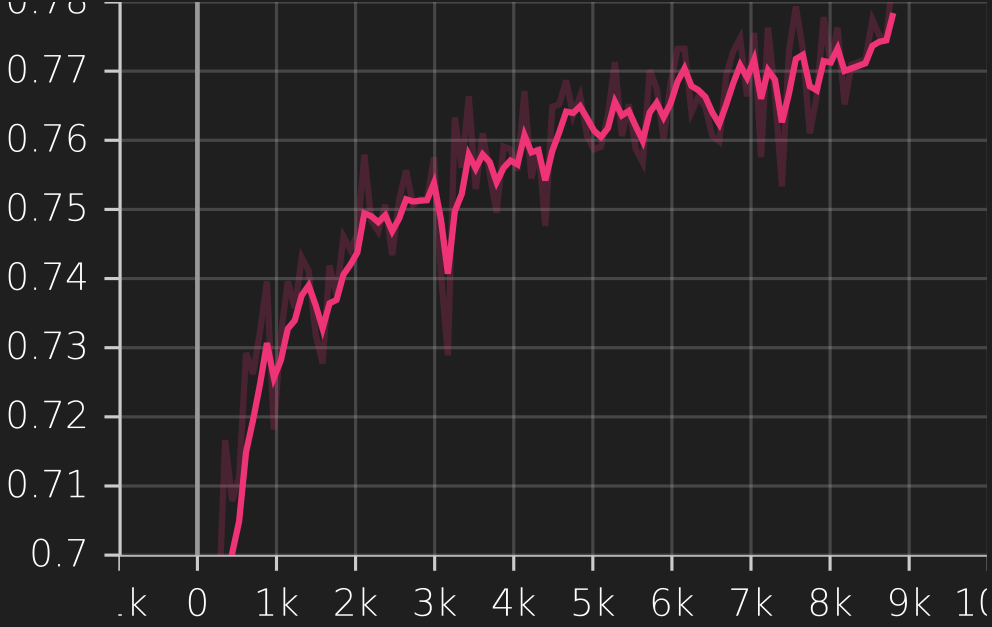

График accuracy на валидации
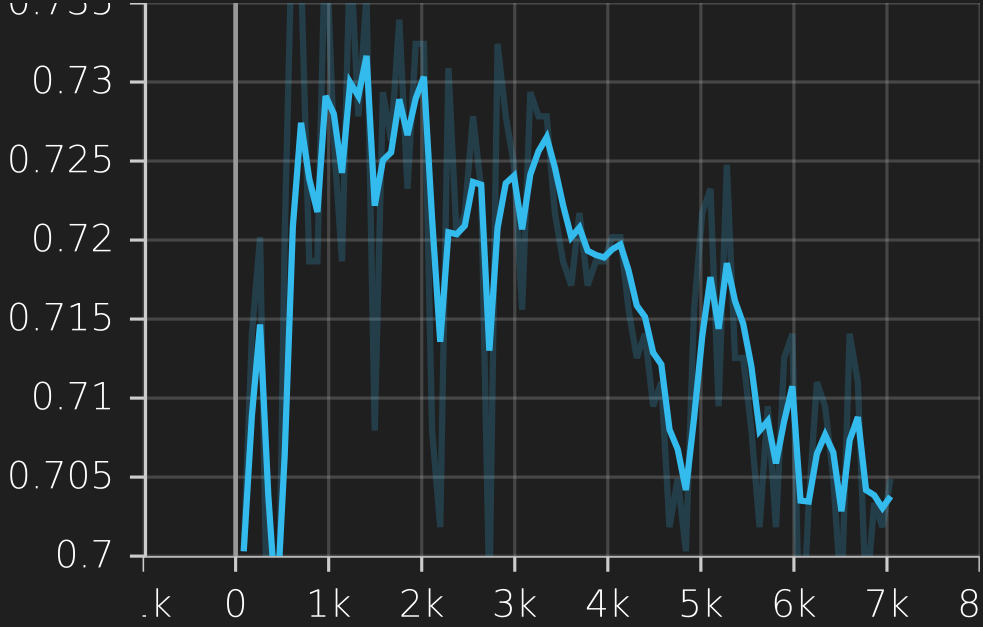

График потерь на тренировочном датасете
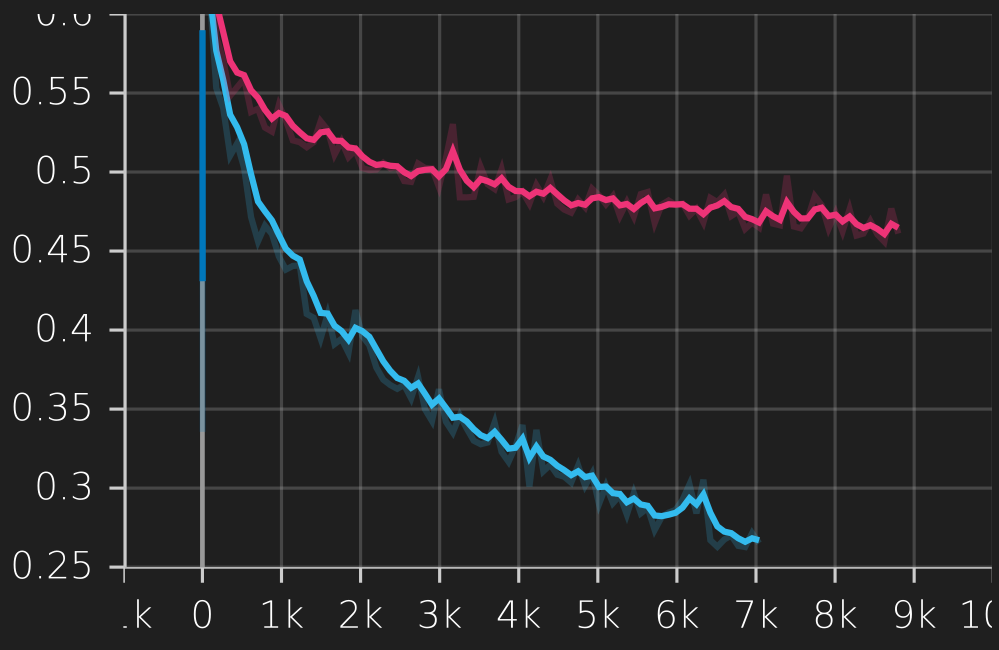

График потерь на валидации
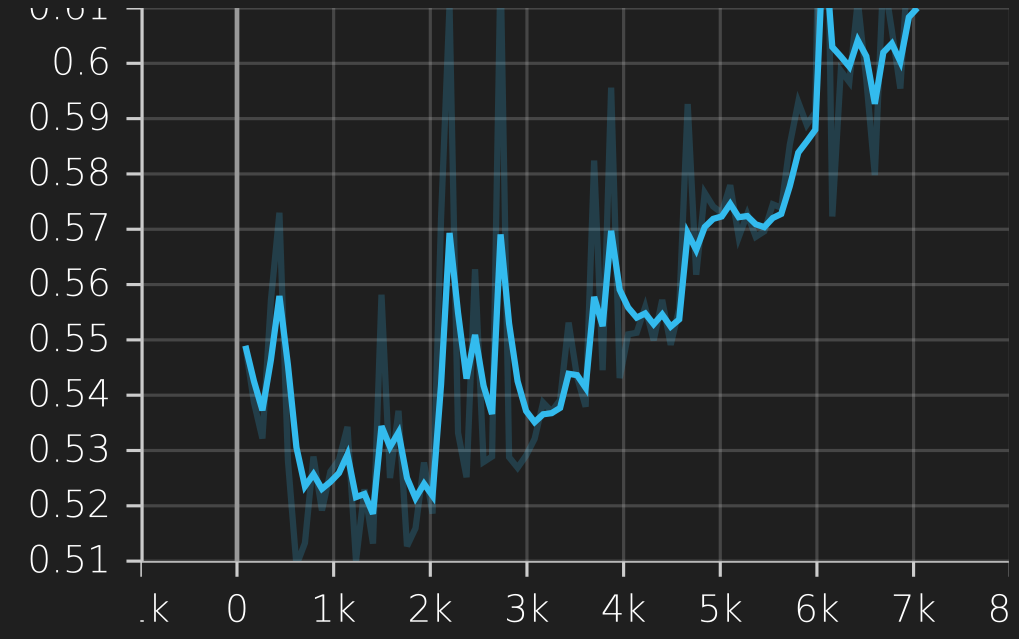

In [111]:
# сохраняю обученную модель
torch.save(model_pl, 'model1_resnet18')

## Обучение второй модели

Шаги обучения последующих моделей идентичны шагам обучения первой

In [40]:
model_c = timm.create_model('convnext_small', pretrained=True, num_classes = 2)

for i, (name, param) in enumerate(model_c.named_parameters()):
    if name == 'head.fc.weight' or name == 'head.fc.bias':
        print(name, param)
        
    else:
        param.requires_grad = False

freezed, unfreezed = 0, 0
for i, param in enumerate(model_c.parameters()):
    if param.requires_grad:
        unfreezed += 1
    else:
         freezed += 1 
print(f"Замороженных слоев: {freezed}\nНезамороженных: {unfreezed}")

head.fc.weight Parameter containing:
tensor([[ 0.0038,  0.0481,  0.0038,  ...,  0.0113, -0.0162, -0.0012],
        [-0.0406,  0.0097, -0.0126,  ...,  0.0135, -0.0119, -0.0343]],
       requires_grad=True)
head.fc.bias Parameter containing:
tensor([0., 0.], requires_grad=True)
Замороженных слоев: 342
Незамороженных: 2


In [41]:
model_c

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (fc2): Linear(in_features=384, out_features=96, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine

In [42]:
# создаю класс для обучения модели
class conv(pl.LightningModule):
    def __init__(self, batch_size = 30, learning_rate = 1e-3):
        super().__init__()
        self.model = model_c
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.train_acc = torchmetrics.Accuracy(task="binary", num_classes=2)
        self.valid_acc = torchmetrics.Accuracy(task="binary", num_classes=2)
        self.test_acc = torchmetrics.Accuracy(task="binary", num_classes=2)
        self.F1 = torchmetrics.F1Score(task="binary", num_classes=2)
        self.prec = torchmetrics.Precision(task="binary", num_classes=2)
        self.rec = torchmetrics.Recall(task="binary", num_classes=2)
       
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):     # процесс обучения

        X, y = batch
        loss = nn.CrossEntropyLoss()     # в качестве функции потреть выбрана Кросс-энтропия
        pred = torch.argmax(self(X), axis = 1)
        self.train_acc(pred, y)
        self.log("train_loss", loss(self(X), y), on_epoch=True, prog_bar=True,\
                 logger=True, enable_graph = True) # log позволяет сохранять данные 
                                                   # для отображения графиков с поомщбю tensorboard
        self.log('train_acc', self.train_acc, on_epoch=True, prog_bar=True,\
                 logger=True, enable_graph = True)
        
        return loss(self(X), y)

    def validation_step(self, batch, batch_idx):   # процесс валидации
        X, y = batch
        pred = torch.argmax(self(X), axis = 1)     # т.к. модель возвращает нам вероятности 
                                                   # принадлежности объекта к классу, для получения
                                                   # предсказания я беру индекс с наибольшим значением
                                                   # вероятности
        self.valid_acc(pred, y)
        valid_loss = nn.CrossEntropyLoss()
        self.log('valid_loss', valid_loss(self(X), y), on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)
        self.log('valid_acc', self.valid_acc, on_epoch=True, prog_bar=True,\
                 logger=True, enable_graph = True)

    def test_step(self, batch, batch_idx):         # процесс тестирования
        X, y = batch

        acc = self.test_acc(torch.argmax(self(X), axis = 1), y)
        F1 = self.F1(torch.argmax(self(X), axis = 1), y)
        prec = self.prec(torch.argmax(self(X), axis = 1), y)
        rec = self.rec(torch.argmax(self(X), axis = 1), y)
                                                    # произведен подсчет метрик качества
        values = {"acc": acc, "F1": F1, "prec": prec, "rec": rec}
        self.log_dict(values)                       # логировать данные можно и при момощи такого
                                                    # способа, в данном случае он был удобнее

        return values                         

        
    def configure_optimizers(self):                 # оптимизатор скорости обучения
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
   


In [43]:
model2_pl = conv()

In [44]:
freezed, unfreezed = 0, 0
for i, param in enumerate(model2_pl.parameters()):
    if param.requires_grad:
        unfreezed += 1
    else:
         freezed += 1 
print(f"Замороженных слоев: {freezed}\nНезамороженных: {unfreezed}")

Замороженных слоев: 342
Незамороженных: 2


In [45]:
train_loader2 = DataLoader(train_set, batch_size=20, shuffle=True)
valid_loader2 = DataLoader(valid_set, batch_size=20, shuffle=False)
test_loader2 = DataLoader(test_set, batch_size=20, shuffle=False)

In [46]:
import time
start_time2 = time.time()
trainer2 = pl.Trainer(limit_train_batches=4000, max_epochs=40)
trainer2.fit(model2_pl, train_loader2, valid_loader2)
finish_time2 = time.time()
lr_time2 = finish_time2 - start_time2

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: C:\Users\nicol\NN\КУРСАЧ\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params
----------------------------------------------
0 | model     | ConvNeXt        | 49.5 M
1 | train_acc | BinaryAccuracy  | 0     
2 | valid_acc | BinaryAccuracy  | 0     
3 | test_acc  | BinaryAccuracy  | 0     
4 | F1        | BinaryF1Score   | 0     
5 | prec      | BinaryPrecision | 0     
6 | rec       | BinaryRecall    | 0     
----------------------------------------------
1.5 K     Trainable params
49.5 M    Non-trainable params
49.5 M    Total params
197.825   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


In [47]:
info2 = trainer2.test(model2_pl, test_loader2)[0]  # тестирую модель
info2['lr_time'] = lr_time2

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            F1             │    0.7394907474517822     │
│            acc            │    0.6968215107917786     │
│           prec            │    0.7215334177017212     │
│            rec            │    0.7695025205612183     │
└───────────────────────────┴───────────────────────────┘

In [48]:
df_info2 = pd.DataFrame(info2.values()).T
df_info2.columns = info2.keys()
df_info2.to_excel('info_convnext_small.xlsx')
df_info2

,acc,F1,prec,rec,lr_time
0,0.696822,0.739491,0.721533,0.769503,39854.005739


In [49]:
torch.save(model2_pl, 'model2_convnext_small')

In [4]:
%reload_ext tensorboard
%tensorboard --logdir model2_convnext_small_logs --host localhost

Reusing TensorBoard on port 6006 (pid 4036), started 0:00:42 ago. (Use '!kill 4036' to kill it.)

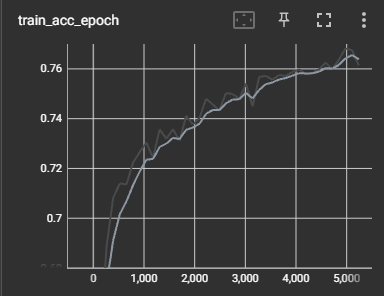

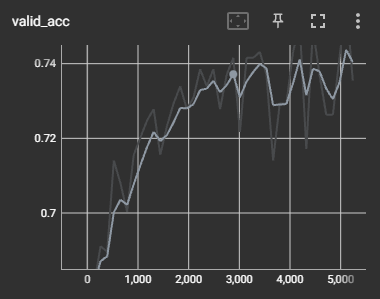

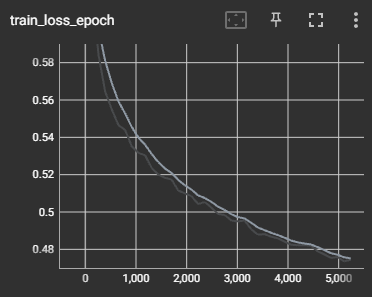

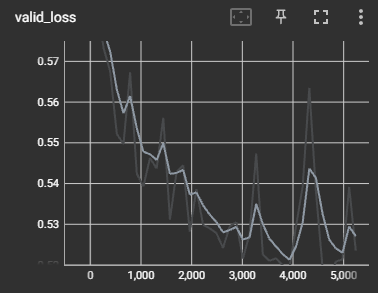

In [22]:
import timm
model_r = timm.create_model('resnet50', pretrained=True, num_classes = 2)

for i, (name, param) in enumerate(model_r.named_parameters()):
    if 'fc' in name:
        continue
    else:
        param.requires_grad = False

freezed, unfreezed = 0, 0
for i, param in enumerate(model_r.parameters()):
    if param.requires_grad:
        unfreezed += 1
    else:
         freezed += 1 
print(f"Замороженных слоев: {freezed}\nНезамороженных: {unfreezed}")

Замороженных слоев: 159
Незамороженных: 2


In [22]:
# создаю класс для обучения модели
class resnet50(pl.LightningModule):
    def __init__(self, batch_size = 30, learning_rate = 1e-3):
        super().__init__()
        self.model = model_r
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.train_acc = torchmetrics.Accuracy(task="binary", num_classes=2)
        self.valid_acc = torchmetrics.Accuracy(task="binary", num_classes=2)
        self.test_acc = torchmetrics.Accuracy(task="binary", num_classes=2)
        self.F1 = torchmetrics.F1Score(task="binary", num_classes=2)
        self.prec = torchmetrics.Precision(task="binary", num_classes=2)
        self.rec = torchmetrics.Recall(task="binary", num_classes=2)
       
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):     # процесс обучения

        X, y = batch
        loss = nn.CrossEntropyLoss()     # в качестве функции потреть выбрана Кросс-энтропия
        pred = torch.argmax(self(X), axis = 1)
        self.train_acc(pred, y)
        self.log("train_loss", loss(self(X), y), on_epoch=True, prog_bar=True,\
                 logger=True, enable_graph = True) # log позволяет сохранять данные 
                                                   # для отображения графиков с поомщбю tensorboard
        self.log('train_acc', self.train_acc, on_epoch=True, prog_bar=True,\
                 logger=True, enable_graph = True)
        
        return loss(self(X), y)

    def validation_step(self, batch, batch_idx):   # процесс валидации
        X, y = batch
        pred = torch.argmax(self(X), axis = 1)     # т.к. модель возвращает нам вероятности 
                                                   # принадлежности объекта к классу, для получения
                                                   # предсказания я беру индекс с наибольшим значением
                                                   # вероятности
        self.valid_acc(pred, y)
        valid_loss = nn.CrossEntropyLoss()
        self.log('valid_loss', valid_loss(self(X), y), on_epoch=True, prog_bar=True,
                 logger=True, enable_graph=True)
        self.log('valid_acc', self.valid_acc, on_epoch=True, prog_bar=True,\
                 logger=True, enable_graph = True)

    def test_step(self, batch, batch_idx):         # процесс тестирования
        X, y = batch

        acc = self.test_acc(torch.argmax(self(X), axis = 1), y)
        F1 = self.F1(torch.argmax(self(X), axis = 1), y)
        prec = self.prec(torch.argmax(self(X), axis = 1), y)
        rec = self.rec(torch.argmax(self(X), axis = 1), y)
                                                    # произведен подсчет метрик качества
        values = {"acc": acc, "F1": F1, "prec": prec, "rec": rec}
        self.log_dict(values)                       # логировать данные можно и при момощи такого
                                                    # способа, в данном случае он был удобнее

        return values                         

        
    def configure_optimizers(self):                 # оптимизатор скорости обучения
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
   


In [24]:
model3_pl = resnet50()

In [25]:
freezed, unfreezed = 0, 0
for i, param in enumerate(model3_pl.parameters()):
    if param.requires_grad:
        unfreezed += 1
    else:
         freezed += 1 
print(f"Замороженных слоев: {freezed}\nНезамороженных: {unfreezed}")

Замороженных слоев: 159
Незамороженных: 2


In [28]:
train_loader3 = DataLoader(train_set, batch_size=15, shuffle=True)
valid_loader3 = DataLoader(valid_set, batch_size=15, shuffle=False)
test_loader3 = DataLoader(test_set, batch_size=15, shuffle=False)

In [29]:
import time
start_time3 = time.time()
trainer3 = pl.Trainer(limit_train_batches=4000, max_epochs=70)
trainer3.fit(model3_pl, train_loader3, valid_loader3)
finish_time3 = time.time()
lr_time3 = finish_time3 - start_time3

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params
----------------------------------------------
0 | model     | ResNet          | 23.5 M
1 | train_acc | BinaryAccuracy  | 0     
2 | valid_acc | BinaryAccuracy  | 0     
3 | test_acc  | BinaryAccuracy  | 0     
4 | F1        | BinaryF1Score   | 0     
5 | prec      | BinaryPrecision | 0     
6 | rec       | BinaryRecall    | 0     
----------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


In [30]:
info3 = trainer3.test(model3_pl, test_loader3)[0]  # тестирую модель
info3['lr_time'] = lr_time3

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\nicol\anaconda3\envs\pyTorch_1_5v2\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            F1             │     0.765716552734375     │
│            acc            │    0.7224938869476318     │
│           prec            │    0.7431073784828186     │
│            rec            │    0.8183378577232361     │
└───────────────────────────┴───────────────────────────┘

In [31]:
df_info3 = pd.DataFrame(info3.values()).T
df_info3.columns = info3.keys()
df_info3.to_excel('info_resnet50.xlsx')
df_info3

,acc,F1,prec,rec,lr_time
0,0.722494,0.765717,0.743107,0.818338,28580.828985


In [33]:
torch.save(model3_pl, 'model3_resnet50')

In [34]:
%reload_ext tensorboard
%tensorboard --logdir model3_resnet50_logs --host localhost

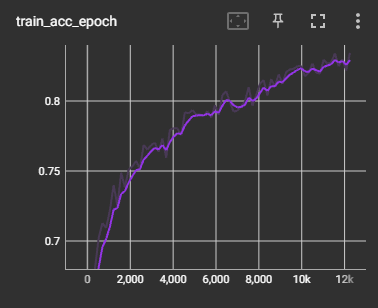

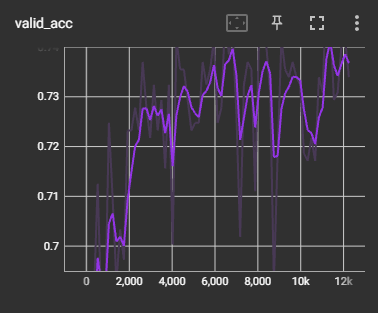

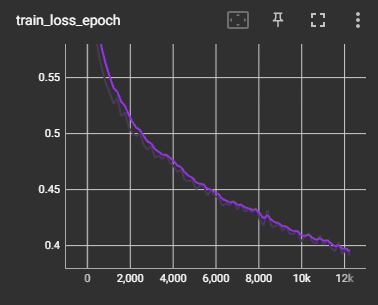

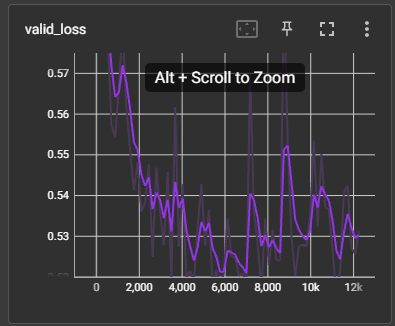

## Информация о процессе обучения моделей

In [47]:
df_inform1 = pd.read_excel('info_resnet18.xlsx')
df_inform2 = pd.read_excel('info_convnext_small.xlsx')
df_inform3 = pd.read_excel('info_resnet50.xlsx')
inform_data = pd.concat([df_inform1, df_inform2, df_inform3]).drop(columns = ['Unnamed: 0'])\
                .rename(columns = {'lr_time':'lr_time_hours'})
inform_data.index = ['resnet18', 'convnext_small', 'resnet50']
inform_data['lr_time_hours'] = (inform_data['lr_time_hours'] / 3600).round(2)
inform_data

,acc,F1,prec,rec,lr_time_hours
resnet18,0.705379,0.721770,0.791806,0.669963,7.36
convnext_small,0.696822,0.739491,0.721533,0.769503,11.07
resnet50,0.722494,0.765717,0.743107,0.818338,7.94


## Информация о моделях

#### Resnet

Сверточные сети имеют проблему затухающих градиентов, это происходит из-за того, что многие функции активации переводят огромное количество входных параметров до гораздо меньшего количества выходных, таким обзазом, большие входные изменения переходят в гораздо меньшие выходные, что приводит к уменьшению градиентов. 
Resnet справляется с этой проблемой при помощи введения остаточных блоков(residual blocks). Ниже представлен пример такого блока, суть которого заключается в добавлении входных параметров к выходным. Этот остаточный блок изменяет цель набора слоев с обучения идеальных весов и порогов F(x) на обучение выхода остаточного блока H(x) = F(x) + x. Переставив члены этого уравнения, получим F(x) = H(x) – x, а это значит, что остаточный блок пытается обучать вход минус выход, иными словами остаточную функцию F(x) – отсюда и название "остаточный блок". 

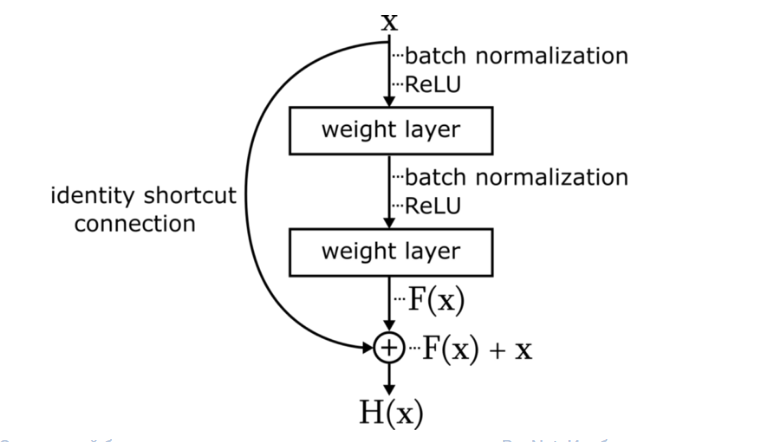

Число в названии модели означает количество слоев в модели, более детально это можно увидеть на изображении ниже
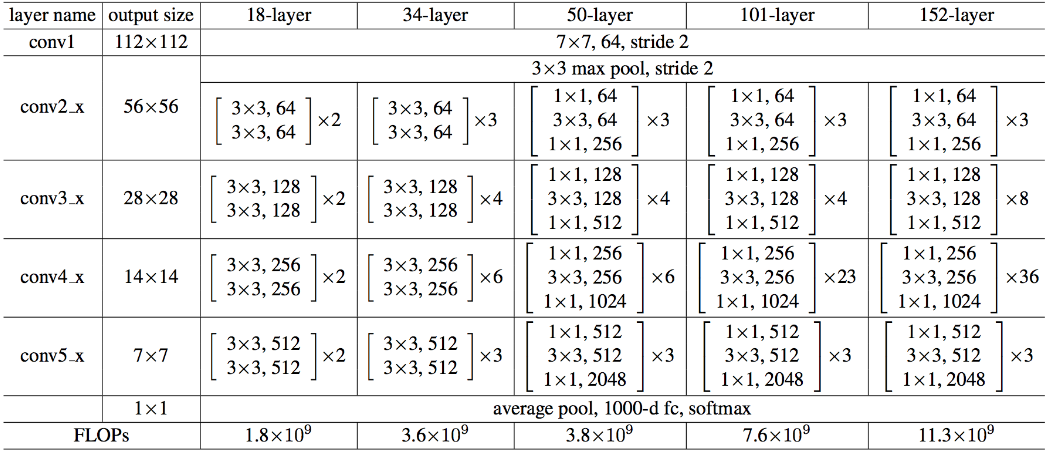

#### Convnext

Архитектура сети Convnext является некоторого рода модификацией сети Resnet, основные отличия заключаются в изменении функции активации(В резнете используется RELU, в конвнексте GELU), графики можно увидеть на картинках ниже
RELU
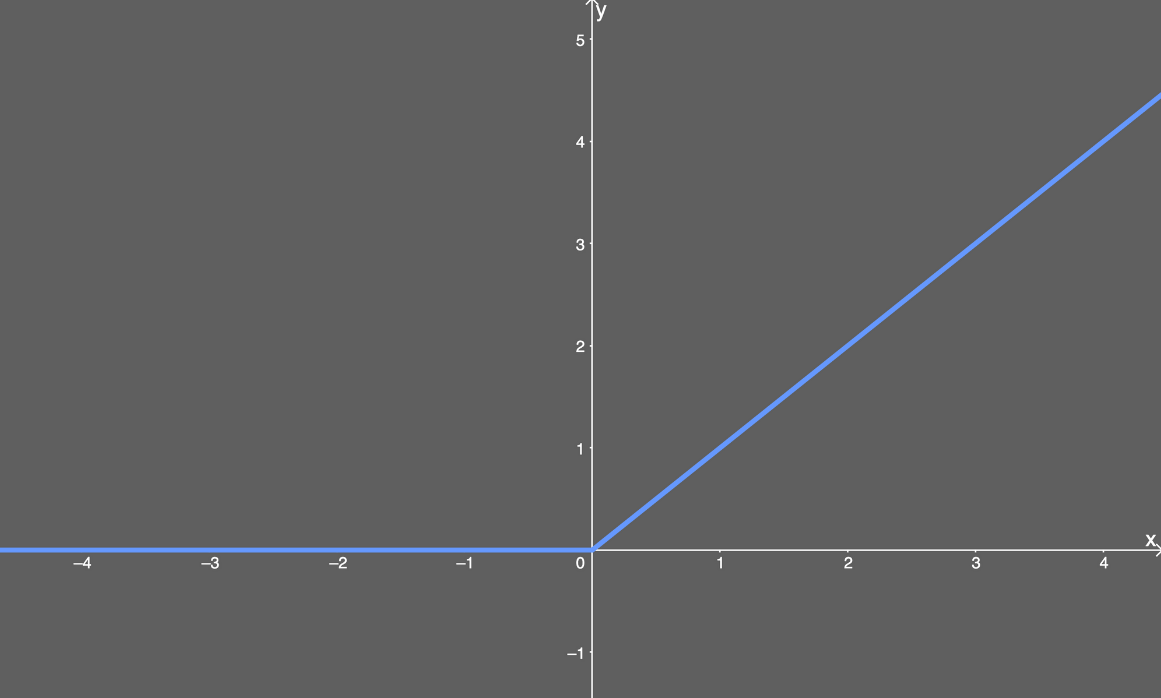
GELU 
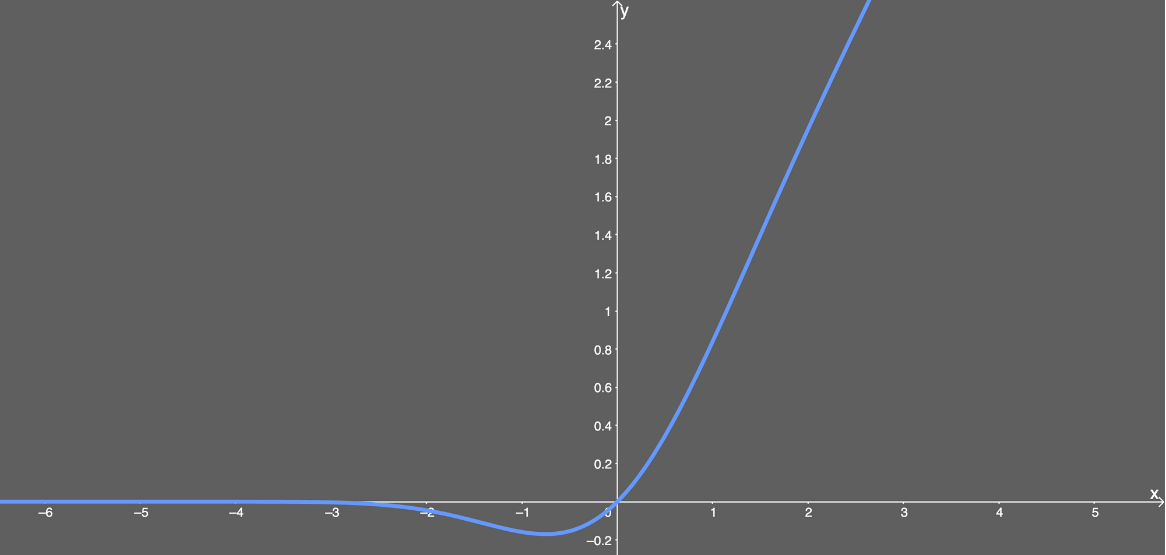
Новая функция активации призвана справляться с проблемами RELU, а именно, dying RELU, это происходит из-за ее производной, график которой выглядит следующим образом:
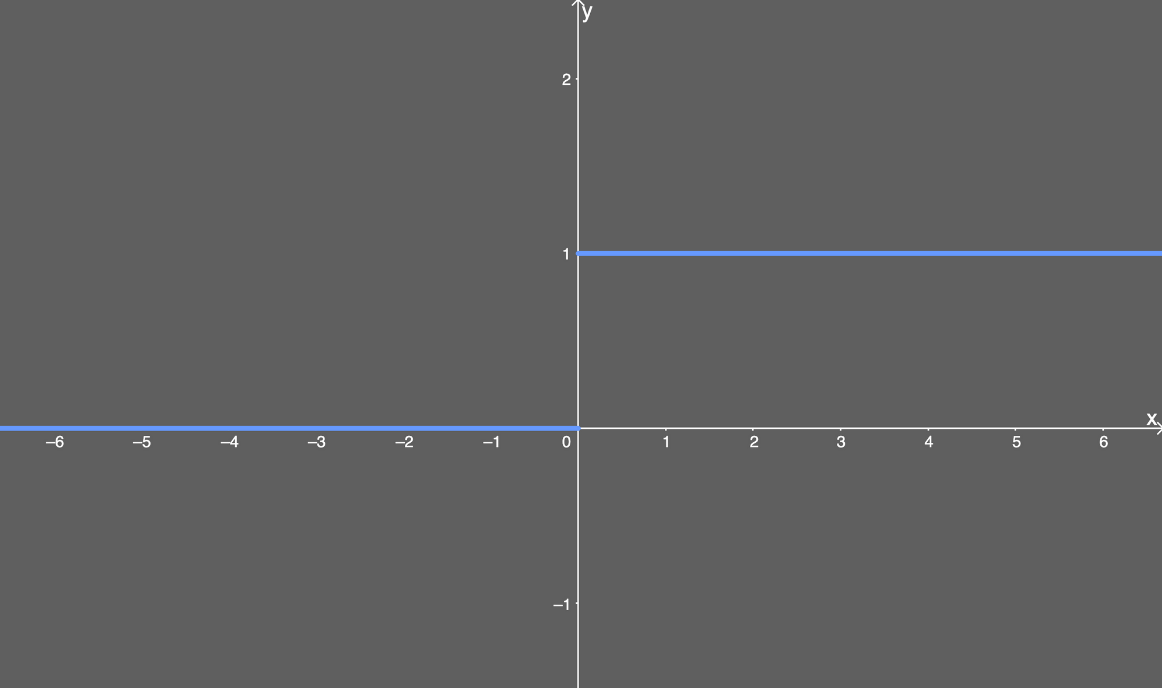
Таким образом, при обратном распространении ошибки мы будем умножать градиенты либо на 0, либо на 1. 
Линейный слой с ReLU в качестве функции активации выглядит как H = max(XW + b, 0). Если b инициализированно достаточно большим отрицательным числом, нейрон умирает.
У GELU такой проблемы не наблюдается, т.к. график ее производной выглядит следующим образом:
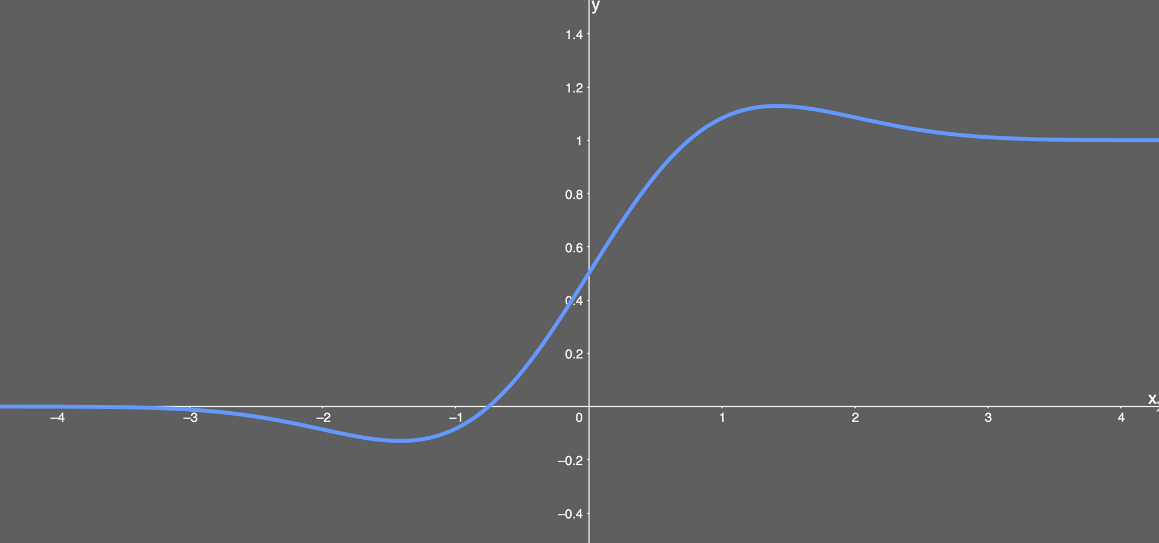
Тем не менее, модель не показала себя лучше резнетов, это связано с тем, что вычисления новой функции активации требуют гораздо больше ресурсов, как можно было видеть по графикам обучения, модель не успела переобучиться за 12 часов, а время в моем случае является чуть ли не наиболее важным параметром

## Загрузка модели и демонстрация результатов

In [ ]:
test_model = torch.load('model3_resnet50')

In [48]:
test_model.eval()

resnet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momen

Класс картинки из датасета : Не поврежден
Предсказание модели : Не поврежден


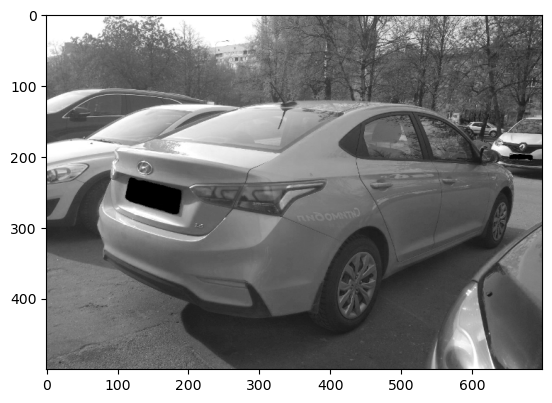

In [28]:
image, label = test_set[598]
plt.imshow(image[0], cmap = 'gray');
print(f'Класс картинки из датасета : {class_names[label]}')
print(f'Предсказание модели : {class_names[torch.argmax(test_model(test_set[598][0].unsqueeze(0))).item()]}')

In [25]:
test_model.eval()

resnet50(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop_block): Identity()
        (act2): ReLU(inplace=True)
        (aa): Identity()
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momen

In [29]:
class_names[torch.argmax(test_model(test_set[598][0].unsqueeze(0))).item()]

'Не поврежден'

Поврежден


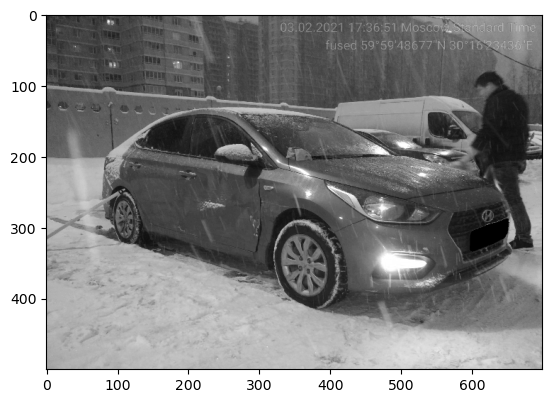

In [30]:
image, label = test_set[458]
plt.imshow(image[0], cmap = 'gray');
print(class_names[label])

In [31]:
class_names[torch.argmax(test_model(test_set[458][0].unsqueeze(0))).item()]

'Поврежден'

Поврежден


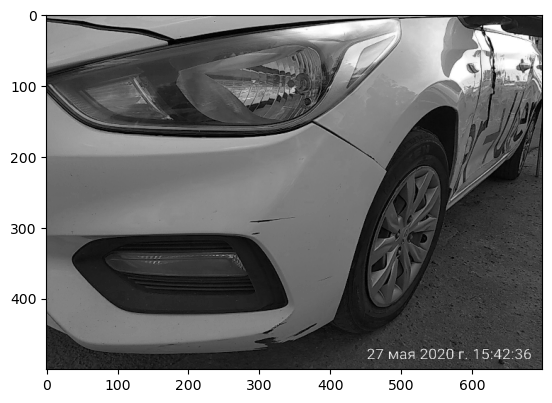

In [32]:
image, label = test_set[698]
plt.imshow(image[0], cmap = 'gray');
print(class_names[label])

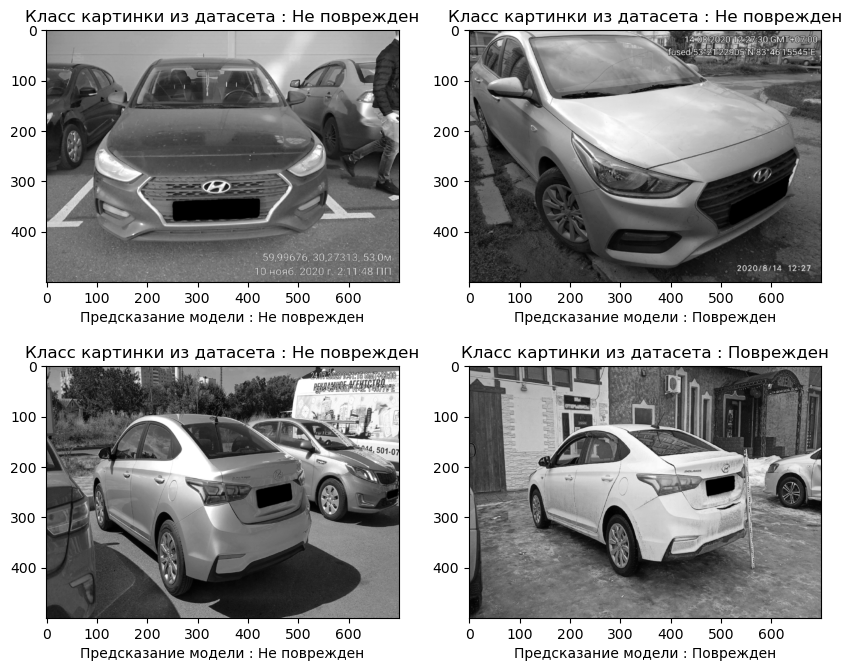

In [87]:
fig, ax = plt.subplots(figsize=(10, 8), nrows=2, ncols=2) 
axes = ax.ravel()
for i in range(4):
    num = np.random.randint(0, test_set.__len__())
    image, label = test_set[num]
    axes[i].imshow(image[0], cmap = 'gray')
    axes[i].set_title(f'Класс картинки из датасета : {class_names[label]}')
    axes[i].set_xlabel(f'Предсказание модели : {class_names[torch.argmax(test_model(test_set[num][0].unsqueeze(0))).item()]}')

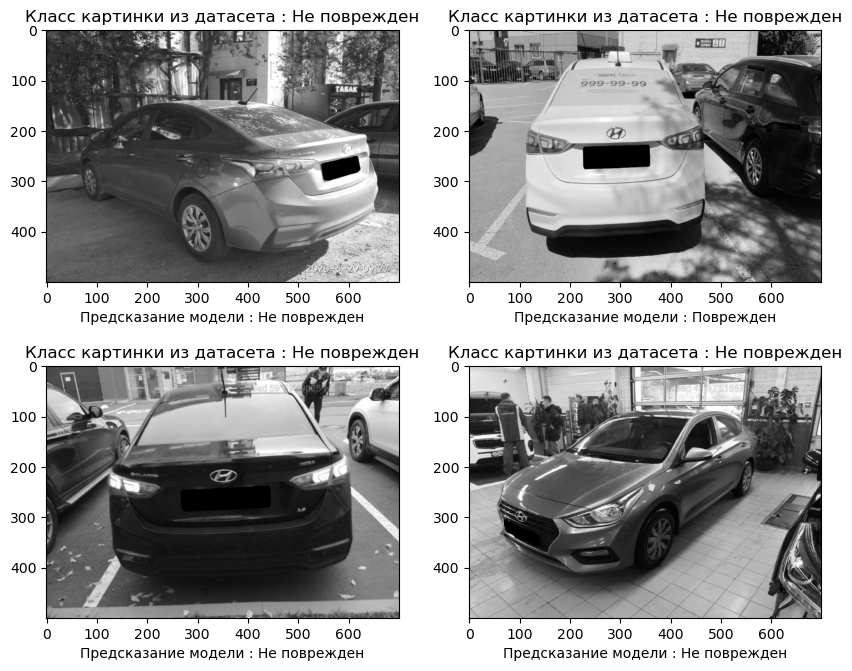

In [89]:
fig, ax = plt.subplots(figsize=(10, 8), nrows=2, ncols=2) 
axes = ax.ravel()
for i in range(4):
    num = np.random.randint(0, test_set.__len__())
    image, label = test_set[num]
    axes[i].imshow(image[0], cmap = 'gray')
    axes[i].set_title(f'Класс картинки из датасета : {class_names[label]}')
    axes[i].set_xlabel(f'Предсказание модели : {class_names[torch.argmax(test_model(test_set[num][0].unsqueeze(0))).item()]}')

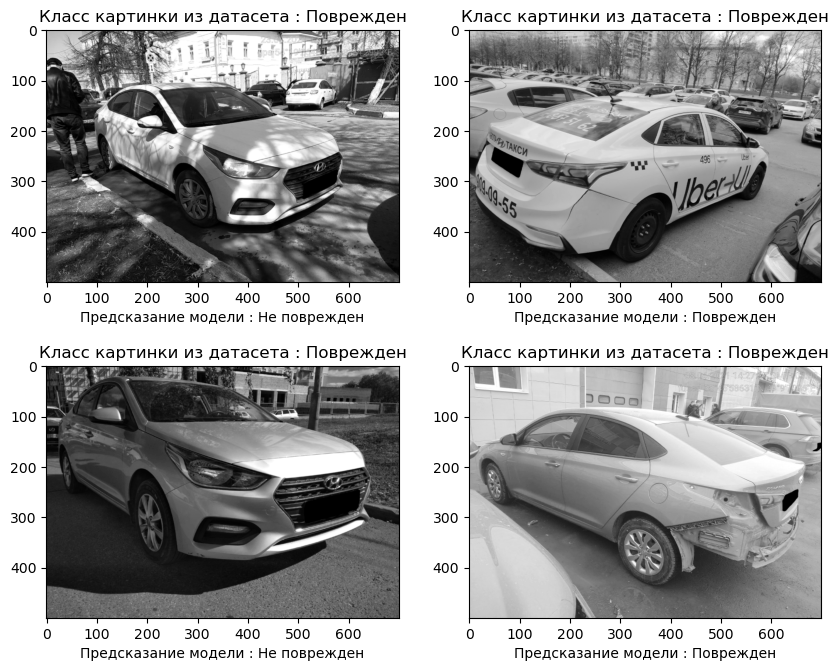

In [92]:
fig, ax = plt.subplots(figsize=(10, 8), nrows=2, ncols=2) 
axes = ax.ravel()
for i in range(4):
    num = np.random.randint(0, test_set.__len__())
    image, label = test_set[num]
    axes[i].imshow(image[0], cmap = 'gray')
    axes[i].set_title(f'Класс картинки из датасета : {class_names[label]}')
    axes[i].set_xlabel(f'Предсказание модели : {class_names[torch.argmax(test_model(test_set[num][0].unsqueeze(0))).item()]}')

## Выводы

В процессе выполнения курсовой работы я приобрел большое количество знаний о том, как устроены сверточные нейронные сети, также изучил библиотеку pytorch lightning, благодаря которой процесс обучения сильно упрощается.
Результаты получились удовлетворительные, пусть метрики трудно назвать шикарными. По визуализации результатов можно видеть, что на некоторых автомобилях, помеченных, как поврежденне, визуально никаких повреждений не видно, это связано с тем, что в датасете для некоторых поврежденных автомобилей представлены фотографии со всех сторон, очевидно, что повреждения с обратной стороны машины распознать невозможно. 